In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm

import metric
from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 4

ROOT = "./../Data/all-cities/"
TRAIN_DIR = "_Train512/"
BACKBONE = 'inceptionv3'

# 'inceptionv3'
# 'densenet121'
# 'resnet34'
# 'vgg16'

Segmentation Models: using `keras` framework.


In [5]:
import get_data_generators

no_augmentation = {
"rotation_range": 0,
"width_shift_range": 0,
"height_shift_range": 0,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "False",
"vertical_flip": "False",
"validation_split": 0.08
}

augmentation = {
"rotation_range": 90,
"width_shift_range": 0.1,
"height_shift_range": 0.1,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "True",
"vertical_flip": "True",
"validation_split": 0.08
}

#augmentation = no_augmentation
train_gen, val_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), ROOT + TRAIN_DIR + "Images", ROOT + TRAIN_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed, preprocess_function=sm.get_preprocessing(BACKBONE))

Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.


In [3]:
"""Load Model backup to resume training after crash or break or for pretraining"""
model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore(), "quality":metric.quality()})
model.compile(optimizer=model.optimizer, loss=model.loss, metrics= model.metrics[1:], run_eagerly=True)
callbacks = create_callbacks(BACKUP_MODEL_PATH)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                         

In [4]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True )

opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH)

model.compile(
    optimizer=opt,
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

history1 = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=12, verbose=1) #,

for layer in model.layers:
    layer.trainable = True

opt = model.optimizer
opt.lr = LEARNING_RATE / 10

model.compile(
    optimizer=opt,
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
)

history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

keys = ['quality', 'iou_score', 'val_iou_score', 'val_quality']
for key in keys:
    history.history[key] = history1.history[key] + history.history[key]


Num GPUs Available:  1
Epoch 1/12
902/901 [==============================] - ETA: 0s - loss: 0.6047 - iou_score: 0.2527 - f1-score: 0.3952 - quality: 0.5127
Epoch 1: val_loss improved from inf to 0.64823, saving model to ./../Models\backup.h5
901/901 [==============================] - 474s 520ms/step - loss: 0.6047 - iou_score: 0.2527 - f1-score: 0.3952 - quality: 0.5127 - val_loss: 0.6482 - val_iou_score: 0.2235 - val_f1-score: 0.3548 - val_quality: 0.4677 - lr: 1.0000e-04
Epoch 2/12
902/901 [==============================] - ETA: 0s - loss: 0.5729 - iou_score: 0.2785 - f1-score: 0.4271 - quality: 0.5454
Epoch 2: val_loss improved from 0.64823 to 0.61204, saving model to ./../Models\backup.h5
901/901 [==============================] - 464s 515ms/step - loss: 0.5729 - iou_score: 0.2785 - f1-score: 0.4271 - quality: 0.5454 - val_loss: 0.6120 - val_iou_score: 0.2452 - val_f1-score: 0.3859 - val_quality: 0.4913 - lr: 1.0000e-04
Epoch 3/12
902/901 [==============================] - ETA: 0s

In [5]:
import datetime

print("Time of saving model:", datetime.datetime.now())

model_path = "./../Models/Binary/512/backbones/bike_mapper_pre-train-scratch-densenet121_Train3607_Val313_Test980_No-Aug.h5"
model.save(model_path)

Time of saving model: 2022-10-28 21:01:15.664278


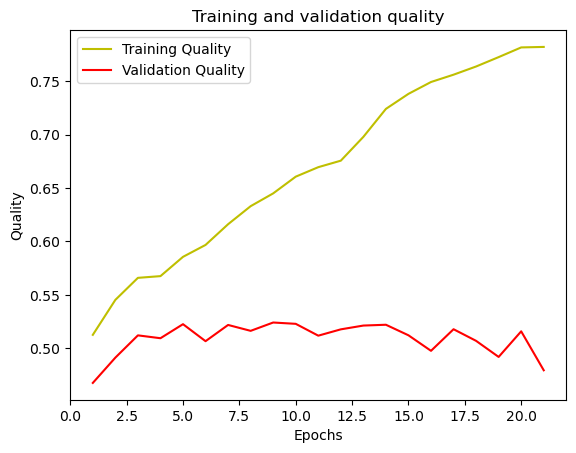

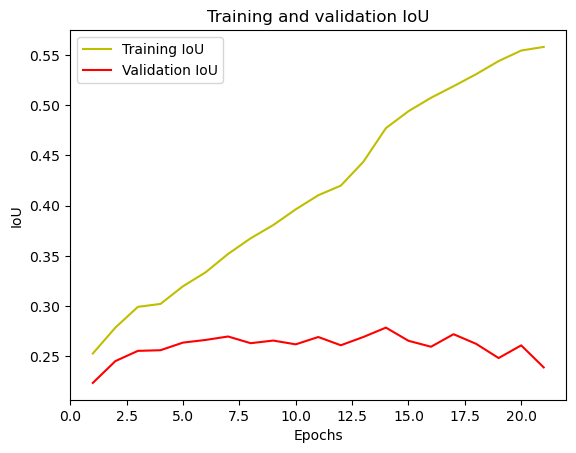

In [6]:
from matplotlib import pyplot as plt

loss = history.history['quality']
val_loss = history.history['val_quality']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Quality')
plt.plot(epochs, val_loss, 'r', label='Validation Quality')
plt.title('Training and validation quality')
plt.xlabel('Epochs')
plt.ylabel('Quality')
plt.legend()
plt.savefig(model_path[:-3] + "__quality.png")

plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig(model_path[:-3] + "__iou.png")
plt.show()

Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Epoch 1/6
1935/1934 [==============================] - ETA: 0s - loss: 0.7822 - iou_score: 0.1258 - f1-score: 0.2178 - quality: 0.3272
Epoch 1: val_loss improved from inf to 0.72672, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 1091s 559ms/step - loss: 0.7822 - iou_score: 0.1258 - f1-score: 0.2178 - quality: 0.3272 - val_loss: 0.7267 - val_iou_score: 0.1631 - val_f1-score: 0.2733 - val_quality: 0.3785 - lr: 1.0000e-04
Epoch 2/6
1935/1934 [==============================] - ETA: 0s - loss: 0.7191 - iou_score: 0.1671 - f1-score: 0.2808 - quality: 0.3985
Epoch 2: val_loss improved from 0.72672 to 0.72321, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 1068s 552ms/step - loss: 0.7191 - iou_score: 0.1671 - f1-score: 0.2808 - quality: 0.3985 - val_loss: 0.7

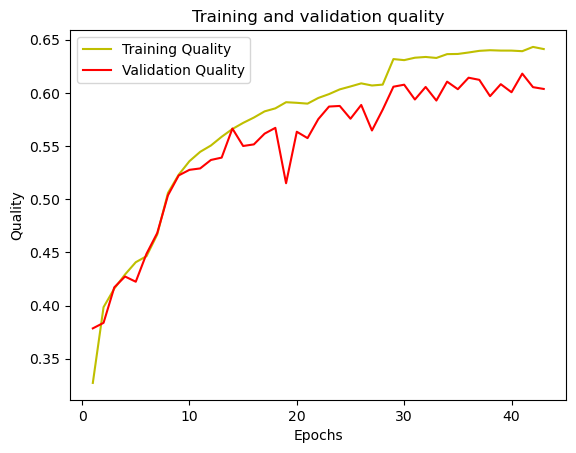

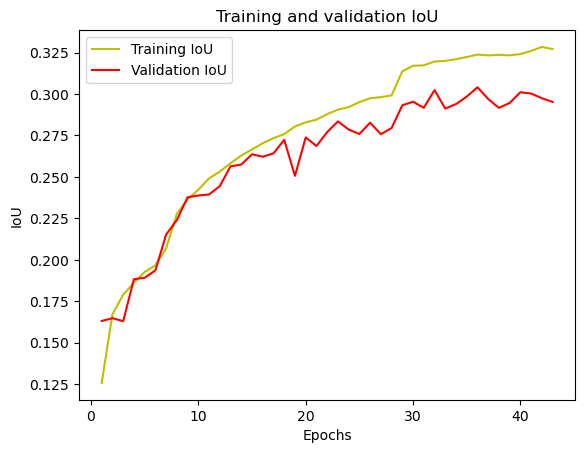

Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 7738 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Epoch 1/6
1935/1934 [==============================] - ETA: 0s - loss: 0.7639 - iou_score: 0.1396 - f1-score: 0.2361 - quality: 0.3612
Epoch 1: val_loss improved from inf to 0.69549, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 1102s 568ms/step - loss: 0.7639 - iou_score: 0.1396 - f1-score: 0.2361 - quality: 0.3612 - val_loss: 0.6955 - val_iou_score: 0.1809 - val_f1-score: 0.3045 - val_quality: 0.4410 - lr: 1.0000e-04
Epoch 2/6
1935/1934 [==============================] - ETA: 0s - loss: 0.6872 - iou_score: 0.1897 - f1-score: 0.3128 - quality: 0.4423
Epoch 2: val_loss improved from 0.69549 to 0.67107, saving model to ./../Models\backup.h5
1934/1934 [==============================] - 1097s 567ms/step - loss: 0.6872 - iou_score: 0.1897 - f1-score: 0.3128 - quality: 0.4423 - val_loss: 0.6

In [ ]:
# 'inceptionv3'
# 'densenet121'
# 'resnet34'
# 'vgg16'

backbones = ['vgg16', 'densenet121', 'inceptionv3', 'resnet34']

for b in backbones:
    BACKBONE = b

    train_gen, val_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), ROOT + TRAIN_DIR + "Images", ROOT + TRAIN_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed, preprocess_function=sm.get_preprocessing(BACKBONE))

    # define model
    model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True )

    opt = keras.optimizers.Adam(LEARNING_RATE)
    callbacks = create_callbacks(BACKUP_MODEL_PATH)

    model.compile(
        optimizer=opt,
        loss=sm.losses.DiceLoss(),
        metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
    )

    history1 = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=6, verbose=1) #,

    for layer in model.layers:
        layer.trainable = True

    opt = model.optimizer
    opt.lr = LEARNING_RATE / 10

    model.compile(
        optimizer=opt,
        loss=sm.losses.DiceLoss(),
        metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True
    )

    history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

    keys = ['quality', 'iou_score', 'val_iou_score', 'val_quality']
    for key in keys:
        history.history[key] = history1.history[key] + history.history[key]

    import datetime

    print("Time of saving model:", datetime.datetime.now())

    model_path = "./../Models/Double-Data/backbones/bike_mapper_pre-train-scratch-" + BACKBONE + "_Aug.h5"
    model.save(model_path)

    from matplotlib import pyplot as plt

    loss = history.history['quality']
    val_loss = history.history['val_quality']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training Quality')
    plt.plot(epochs, val_loss, 'r', label='Validation Quality')
    plt.title('Training and validation quality')
    plt.xlabel('Epochs')
    plt.ylabel('Quality')
    plt.legend()
    plt.savefig(model_path[:-3] + "__quality.png")

    plt.show()

    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']

    plt.plot(epochs, acc, 'y', label='Training IoU')
    plt.plot(epochs, val_acc, 'r', label='Validation IoU')
    plt.title('Training and validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.savefig(model_path[:-3] + "__iou.png")
    plt.show()